In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Carregamento de bibliotecas

In [2]:
from sklearn.svm import SVC
from sklearn.utils import shuffle
from time import time as tick
import numpy as np
import imageio as iio
import math

### Programa

#### Carregamento de imagens de treino e de teste

In [3]:
dir_training = 'DRIVE/training/images/'
dir_test = 'DRIVE/test/images/'
dir_sol1_test = 'DRIVE/test/1st_manual/'
dir_sol2_test = 'DRIVE/test/2nd_manual/'
dir_mask_training = 'DRIVE/training/new_mask/'
dir_mask_test = 'DRIVE/test/new_mask/'
dir_sol_training = 'DRIVE/training/1st_manual/'

N = 20
training = []
sol_training = []
masks_training = []
test = []
sol1_test = []
sol2_test = []
mask_test = []

for i in range(N):
    
    #training images and masks
    training.append(255-iio.imread(dir_training + str(20+i+1)+'_training.tif')[:,:,1].astype(np.float64))
    #training.append(255-iio.imread(dir_training + str(20+i+1)+'_training.tif')[:,:,1])
    sol_training.append(iio.imread(dir_sol_training + str(20+i+1)+'_manual1.gif'))
    masks_training.append(iio.imread(dir_mask_training + str(20+i+1)+'_training_mask.gif'))
    
    #test images and masks
    if i<9:
        pre = '0'
    else:
        pre = ''
    test.append(255-iio.imread(dir_test + pre +str(i+1)+'_test.tif')[:,:,1].astype(np.float64))
    sol1_test.append(iio.imread(dir_sol1_test + pre  + str(i+1)+'_manual1.gif'))
    sol2_test.append(iio.imread(dir_sol2_test + pre  + str(i+1)+'_manual2.gif'))
    mask_test.append(iio.imread(dir_mask_test + pre +str(i+1)+'_test_mask.gif'))
    
    #plot some images to check
    #if i%5 ==0:
    #    plt.imshow(mask_test[i], cmap = 'gray')
    #    plt.figure()


#### Determinação dos parâmetros das imagens:  line strength, orthogonal line strength e intensidade-  x = [S, So, I]

Função que determina as 12 retas cuja inclinação incrementa de 15 graus. Devolve uma matriz 12x15x2 com as coordenadas dos pontos da reta. Faz o mesmo para as respetivas 12 linhas ortogonais de 3 pontos.

In [4]:
def lines_opt(l = 15, c = 15, centerx = 7, centery = 7, deg_step = 15, n_steps = 12):
    #returns coordinates of the pixels in a 15x15 window correspondent to the lines calculated
    
    lines = np.zeros((l, c), int) 
    lines_plot = np.zeros((n_steps, l, c), int) 
    lines_coord = np.zeros((n_steps, l, 2), int)
    lines_ort_plot = np.zeros((n_steps, l, c), int) 
    lines_ort_coord = np.zeros((n_steps, 3, 2), int)
    
    for i in range(n_steps):
        for j in range(c):
            #evaluate value of funciton y = slope*x where x is the pixel count within the center pixel(0,0)
            j_ = j
            j_ort = j
            
            if deg_step*i<=45 or deg_step*i>=135:
                slope = tan(deg_step*i*math.pi/180.0)
                lines[i, j] = max(min(c-1-round(slope*(j-centerx) + centery), l-1), 0)  
                
            else:
                slope = tan(deg_step*i*math.pi/180.0 - math.pi/2.)
                lines[i,j] = j
                j_ = max(min(round(slope*(lines[i,j]-centerx) + centery), l-1), 0)
            
            lines_plot[i, lines[i, j], j_ ] = 1
            lines_coord[i,j,0] = lines[i, j]
            lines_coord[i,j,1] = j_
            
            
            
    lines_ort_coord[:, :, :] = np.roll(lines_coord[:, centerx-1:centerx+2, :],6,axis=0)
    for i in range(n_steps):
        lines_ort_plot[i][lines_ort_coord[i, :, 0], lines_ort_coord[i, :, 1]] = 1
    
    #print(lines_ort_coord)
    
    i = 0
    _, axs = plt.subplots(2,6,figsize=[12,4],constrained_layout=True)
    _, axs2 = plt.subplots(2,6,figsize=[12,4],constrained_layout=True)
    for il in range(2):
        for ic in range(6):
            axs[il, ic].imshow(lines_plot[i])
            axs[il, ic].set_title(str(i*deg_step) + ' degrees')
            
            axs2[il, ic].imshow(lines_ort_plot[i])
            axs2[il, ic].set_title(str(i*deg_step) + ' degrees')
            i = i + 1    
    
    return lines_coord, lines_ort_coord


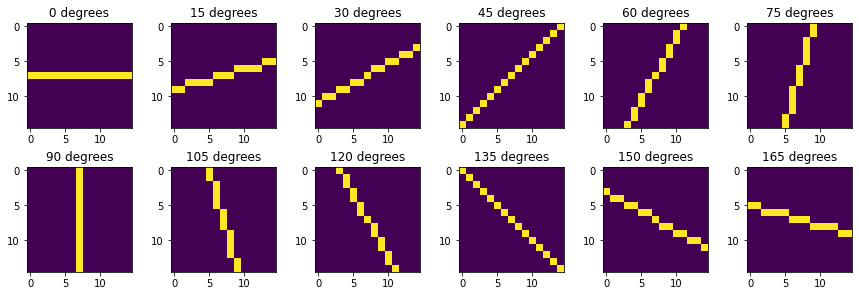

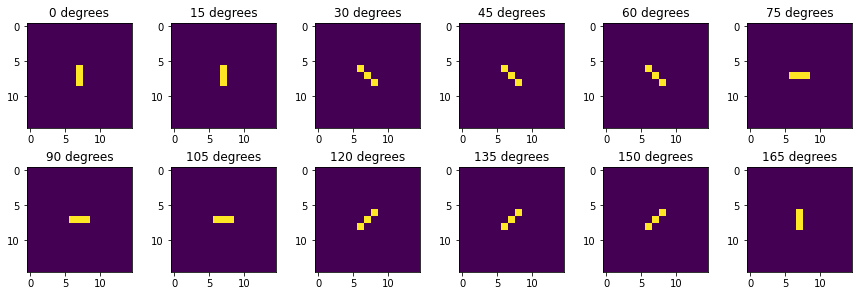

In [5]:
l, l_ort = lines_opt()
#print(l)

Função que sorteia os pontos dos quais se vão determinar os pârametros da imagem.

In [6]:
def random_pixels(mask, NL, NC, N):
    li, lj = [], []
    while True:
        i = randint(0, NL)
        j = randint(0, NC)
        
        if mask[i,j]>0:
            li.append(i)
            lj.append(j)
            if len(li)>N:
                break
    return li, lj

### Função para uma imagem inteira

Função que determina os parâmetros para todos os pontos aleatórios da imagem passada como argumento. 

In [6]:
#funciona!!

def parameters_opt(img_, mask_, sol_,lines, lines_ort, N = 1000):
    N = 5
    n_lines = 12
    dim = 7
    iline_main = 0
        

    NL, NC = np.shape(img_)
    
    #padding
    img = np.pad(img_, ((dim, dim), (dim, dim)))
    mask = np.pad(mask_, ((dim, dim), (dim, dim)))
    sol = np.pad(sol_, ((dim, dim), (dim, dim)))
    
    plt.imshow(img)
    plt.figure()
    plt.imshow(mask)
    plt.figure()
    
    
    S = np.zeros((N**2), float )
    S_test = img.copy()
    I_test = img.copy()
    So_test = img.copy()
    Y_test = img.copy()
    S_test[:] = 0
    So_test[:] = 0
    I_test[:] = 0
    Y_test[:] = 0
    
    print(NL, NC)
    
    count = 0
            
    #teste
    for i in range(dim, NL+dim):
        for j in range(dim, NC+dim):
            
            if mask[i,j]!=0:
                #teste
                #retrieve window around pixel and treat border points
                mask_window = mask[i - dim: i + dim + 1, j - dim: j + dim + 1]
                pixel_window = img[i - dim: i + dim + 1, j - dim: j + dim + 1]
                
                if mask_window[0,0]==0 or mask_window[14,14]==0 or mask_window[0,14]==0 or mask_window[14,0]==0:
                    pixel_window[mask_window == 0] = np.mean(pixel_window[mask_window != 0])
                
                N_ = np.mean(pixel_window)
                
                #pixel intensity
                Y_test[i,j] = sol[i,j]
                 
                #determine L
                #should save the intensities of the lines, given that we know the coordinates from the preloaded lines
                L = np.mean(pixel_window[lines[0,:,0], lines[0,:,1]])
                for i_line in range(1, n_lines):
                    lines_int = pixel_window[lines[i_line,:,0], lines[i_line,:,1]].mean()
                    L_ = L
                    L = max(lines_int, L)
                    if L != L_:
                        iline_main = i_line
                               
                
                S_test[i,j] = L - N_
                
                Lo = np.mean(pixel_window[lines_ort[iline_main, :, 0], lines_ort[iline_main, :, 1]]) 
                So_test[i,j] = Lo - N_
                
                I_test[i,j] = img[i,j]
                
    #normalize vector to not consider brightness variations
    S_test[I_test != 0] = (S_test[I_test != 0] - np.mean(S_test[I_test != 0]))/np.std(S_test[I_test != 0])
    So_test[I_test != 0] = (So_test[I_test != 0] - np.mean(So_test[I_test != 0]))/np.std(So_test[I_test != 0])
    I_test[I_test != 0] = (I_test[I_test != 0] - np.mean(I_test[I_test != 0]))/np.std(I_test[I_test != 0])
    
    #teste
    #plt.imshow(S_test)
    print('Fim')
     
    return S_test, So_test, I_test, Y_test

584 565
Fim
58.7519805431366


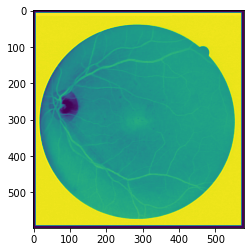

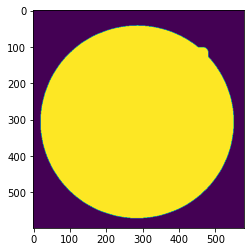

<Figure size 432x288 with 0 Axes>

In [7]:

t1 = time.time()
S_test1, So_test1, I_test1, Y_test1 = parameters_opt(training[0], masks_training[0], sol_training[0], l, l_ort)
t2 = time.time()
print(t2-t1)


Construir vetor, X e Y, na forma correta

In [13]:
dim = 7
S_test1_f = (S_test1[dim:-dim, dim:-dim]).flatten()
So_test1_f = (So_test1[dim:-dim, dim:-dim]).flatten()
I_test1_f = (I_test1[dim:-dim, dim:-dim]).flatten()
Y_test1_f = (Y_test1[dim:-dim, dim:-dim]).flatten()
mask_f = (masks_training[0]).flatten()

S_tes1_final = S_test1_f
So_tes1_final = So_test1_f
I_tes1_final = I_test1_f
Y_tes1_final = Y_test1_f

print(np.shape(S_tes1_final), np.shape(So_tes1_final),np.shape(I_tes1_final),np.shape(Y_tes1_final))

length = np.shape(S_tes1_final)[0] - np.shape(I_test1_f[I_test1_f==0])[0]

print(length)
print('Pontos iniciais totais: ', np.shape(S_tes1_final)[0])
print('Pontos removidos: ',np.shape(I_test1_f[I_test1_f==0])[0])
print('Pontos removidos em baixo: ',np.shape(I_tes1_final[I_tes1_final==0])[0])
print('Pontos aceites no final: ', np.shape(S_tes1_final[I_tes1_final!=0])[0])

X = np.zeros((length, 3), float)
Y = np.zeros((length), float)

X[:,0] = S_tes1_final[I_tes1_final!=0]
X[:,1] = So_tes1_final[I_tes1_final!=0]
X[:,2] = I_tes1_final[I_tes1_final!=0]
Y[:] = Y_tes1_final[I_tes1_final!=0]

print(X)
print(Y)

(329960,) (329960,) (329960,) (329960,)
220054
Pontos iniciais totais:  329960
Pontos removidos:  109906
Pontos removidos em baixo:  109906
Pontos aceites no final:  220054
[[-0.70219069 -0.84001196 -0.74733635]
 [-0.68922261 -0.70776122 -0.57402796]
 [-0.8116807  -2.26943232 -0.80510582]
 ...
 [-0.45696762 -0.31767259  1.27459487]
 [-0.46259653 -0.20292509  1.33236433]
 [-0.29820887  0.05469037  1.56344219]]
[0. 0. 0. ... 0. 0. 0.]


Criar classificador

In [14]:
clf = SVC(kernel='rbf', gamma=0.05)

Treinar o classificador

In [15]:
t1 = time.time()
clf = clf.fit(X, Y)
t2 = time.time()
print(t2-t1)

396.5071032047272


Prever resultado

In [ ]:
t1 = time.time()
y_pred_train = clf.predict(X)
t2 = time.time()
print(t2-t1)

Avaliar o resultado

In [ ]:
print("Taxa de sucesso (Treino): ",
      np.mean(y_pred_train == Y) * 100)

### Pontos random para treino

In [7]:
def parameters_opt_random(img_, mask_, sol_, lines, lines_ort, N = 1000):
    n_lines = 12
    dim = 7
    iline_main = 0
        

    NL, NC = np.shape(img_)[0], np.shape(img_)[1]
    
    #padding
    img = np.pad(img_, ((dim, dim), (dim, dim)))
    mask = np.pad(mask_, ((dim, dim), (dim, dim)))
    sol = np.pad(sol_, ((dim, dim), (dim, dim)))
    
    #plt.imshow(img)
    #plt.figure()
    #plt.imshow(mask)
    #plt.figure()
    
    
    S = []
    So = []
    I = []
    Y = []
    
    
    print(NL, NC)
    
    
    #sortetamento de pixeis 
    li, lj = random_pixels(mask, NL + dim*2, NC + dim*2, N)
    
    count = 0    
    for j in range(N):
            if count%1000==0:
                print("Hello", str(count))
    #teste
    #for i in range(dim, NL+dim):
    #    for j in range(dim, NC+dim):
            
            mask_window = mask[li[j] - dim: li[j] + dim + 1, lj[j] - dim: lj[j] + dim + 1]
            pixel_window = img[li[j] - dim: li[j] + dim + 1, lj[j] - dim: lj[j] + dim + 1]
            
            #teste
            #retrieve window around pixel and treat border points
            #mask_window = mask[i - dim: i + dim + 1, j - dim: j + dim + 1]
            #pixel_window = img[i - dim: i + dim + 1, j - dim: j + dim + 1]
            
            if mask_window[0,0]==0 or mask_window[14,14]==0 or mask_window[0,14]==0 or mask_window[14,0]==0:
                pixel_window[mask_window == 0] = np.mean(pixel_window[mask_window != 0])
            
            N_ = np.mean(pixel_window)
            
            #pixel intensity
            I.append(img[li[j],lj[j]])
            Y.append(sol[li[j],lj[j]])
             
            #determine L
            #should save the intensities of the lines, given that we know the coordinates from the preloaded lines
            L = np.mean(pixel_window[lines[0,:,0], lines[0,:,1]])
            for i_line in range(1, n_lines):
                lines_int = pixel_window[lines[i_line,:,0], lines[i_line,:,1]]
                L_ = L
                L = max(np.mean(lines_int), L)
                if L != L_:
                    iline_main = i_line
                            
            S.append(L - N_)
            
            Lo = np.mean(pixel_window[lines_ort[iline_main, :, 0], lines_ort[iline_main, :, 1]]) 
            So.append(Lo - N_)
            count = count + 1
            #I_test[i,j] = img[i,j]
                
    #normalize vector to not consider brightness variations
    S = (S - np.mean(S))/np.std(S)
    So = (So - np.mean(So))/np.std(So)
    I = (I - np.mean(I))/np.std(I)
    
    #teste
    #plt.imshow(S_test)
    print('Fim')
     
    return S, So, I, Y

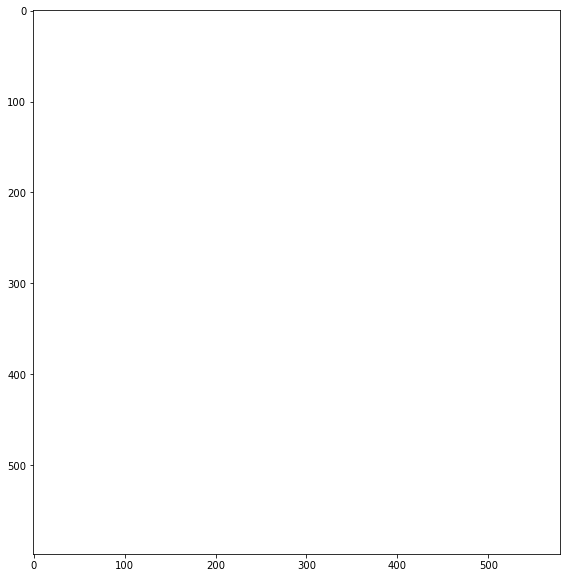

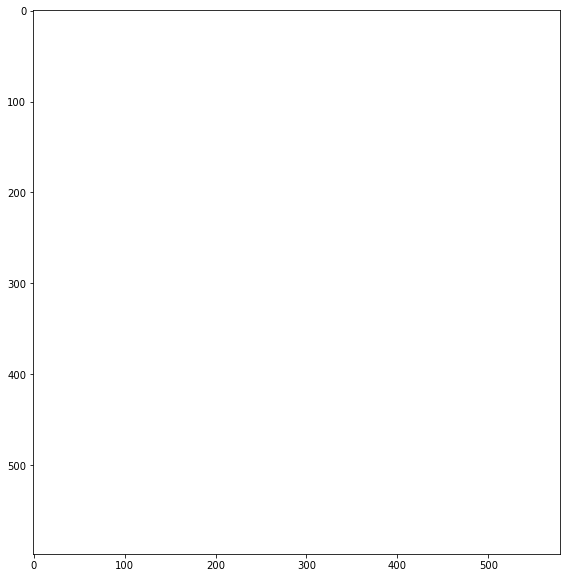

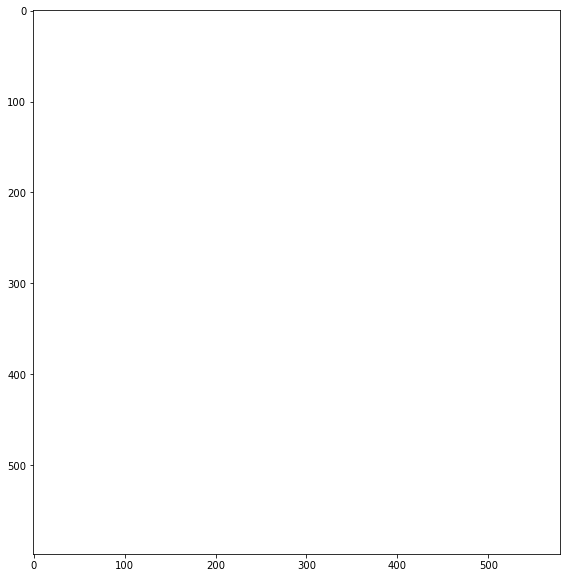

In [79]:

plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(S_test1)

plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(So_test1)

plt.figure(figsize=(10,10))
plt.gray()
plt.imshow(I_test1)


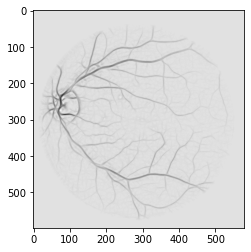

In [27]:
plt.imshow(-1*S_test1 + 255)

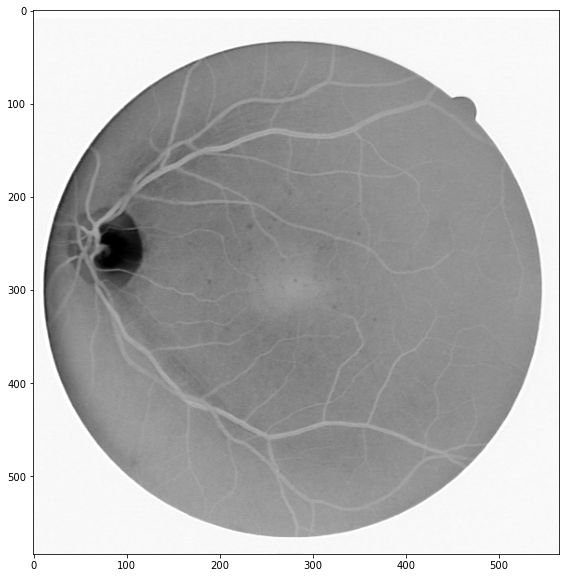

In [72]:

plt.figure(figsize = (10,10))
plt.gray()
plt.imshow(training[0])

#### Tirar features para cada imagem de treino e respetiva solução das imagens manual

In [17]:
n = 1000
print(N)
X = np.zeros((N*n, 3), float)
Y = np.zeros((N*n), float)

for i in range(N):
    S_test, So_test, I_test, Y_test = parameters_opt_random(training[i], masks_training[i], sol_training[i], l, l_ort)
    X[i*n:(i+1)*n, 0] = S_test
    X[i*n:(i+1)*n, 1] = So_test
    X[i*n:(i+1)*n, 2] = I_test
    Y[i*n:(i+1)*n] = Y_test

20
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim
584 565
Hello 0
Fim


In [20]:
r = np.zeros((N*n, 4), float)
r[:, 0:3] = X
r[:,3] = Y
r

array([[ 2.61022591e+00, -4.24256941e-01, -7.06082568e-01,
         2.55000000e+02],
       [-3.04253158e-01,  3.70468343e-02,  3.31631602e-01,
         0.00000000e+00],
       [-4.84686409e-01, -5.94717835e-01,  1.67781996e-01,
         0.00000000e+00],
       ...,
       [-2.06632246e-01,  2.28654588e-01, -1.33562555e-01,
         0.00000000e+00],
       [ 2.59980169e+00,  1.68423035e+00,  2.20822347e+00,
         2.55000000e+02],
       [ 1.98898066e+00,  2.15578522e+00,  1.40071105e+00,
         2.55000000e+02]])

In [22]:
print(np.shape(r[:, 0:3]))
print(np.shape(r[:, 3]))
print(X)
print(Y)

(20000, 3)
(20000,)
[[ 2.61022591 -0.42425694 -0.70608257]
 [-0.30425316  0.03704683  0.3316316 ]
 [-0.48468641 -0.59471784  0.167782  ]
 ...
 [-0.20663225  0.22865459 -0.13356255]
 [ 2.59980169  1.68423035  2.20822347]
 [ 1.98898066  2.15578522  1.40071105]]
[255.   0.   0. ...   0. 255. 255.]


#### Criar o classificador

In [23]:
clf = SVC(kernel='rbf', gamma=0.05)

### Treinar o classificador

In [25]:
t1 = time.time()
clf = clf.fit(r[:, 0:3], r[:, 3])
t2 = time.time()
print(t2-t1)

6.020193099975586


In [28]:
t1 = time.time()
y_pred_train = clf.predict(r[:, 0:3])
t2 = time.time()
print(t2-t1)

11.637089252471924


In [29]:
print("Taxa de sucesso (Treino): ",
      np.mean(y_pred_train == r[:, 3]) * 100)

Taxa de sucesso (Treino):  93.77


### Experimentar numa imagem inteira do treino

584 565
Fim


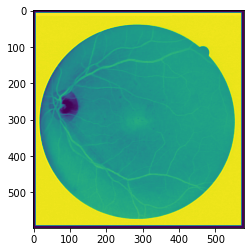

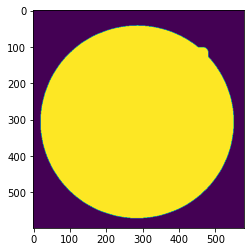

<Figure size 432x288 with 0 Axes>

In [38]:
S_test1, So_test1, I_test1, Y_test1 = parameters_opt(training[0], masks_training[0], sol_training[i], l, l_ort)

In [43]:
dim = 7

print(np.shape(masks_training[0]))
print(np.shape(Y_test1[dim:-dim, dim:-dim]))

(584, 565)
(584, 565)


In [50]:
dim = 7
S_test1_f = (S_test1[dim:-dim, dim:-dim]).flatten()
So_test1_f = (So_test1[dim:-dim, dim:-dim]).flatten()
I_test1_f = (I_test1[dim:-dim, dim:-dim]).flatten()
Y_test1_f = (Y_test1[dim:-dim, dim:-dim]).flatten()
mask_f = (masks_training[0]).flatten()

S_tes1_final = S_test1_f[mask_f!=0]
So_tes1_final = So_test1_f[mask_f!=0]
I_tes1_final = I_test1_f[mask_f!=0]
Y_tes1_final = Y_test1_f[mask_f!=0]

print(np.shape(S_tes1_final), np.shape(So_tes1_final),np.shape(I_tes1_final),np.shape(Y_tes1_final))

length = np.shape(S_tes1_final)[0]

(220382,) (220382,) (220382,) (220382,)


In [51]:
print(length)

X = np.zeros((length, 3), float)
Y = np.zeros((length), float)

X[:,0] = S_tes1_final
X[:,1] = So_tes1_final
X[:,2] = I_tes1_final
Y[:] = Y_tes1_final

print(X)



220382
[[-0.42596823 -1.05925061  0.47996151]
 [-0.42596823 -0.78718331  0.52582296]
 [-0.42596823 -2.69165436  0.46467435]
 ...
 [-0.42596823 -0.24304873  1.01501185]
 [-0.42596823 -0.24304873  1.03029901]
 [-0.10141413  0.02901856  1.09144762]]
[0. 0. 0. ... 0. 0. 0.]


In [52]:
numpy.set_printoptions(threshold=sys.maxsize)
print(Y)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 255. 255. 255. 255. 255.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 

In [53]:
t1 = time.time()
y_pred_train = clf.predict(X)
t2 = time.time()
print(t2-t1)

134.00609254837036


In [54]:
print("Taxa de sucesso (Treino): ",
      np.mean(y_pred_train == Y) * 100)

Taxa de sucesso (Treino):  80.26381464910928


329960


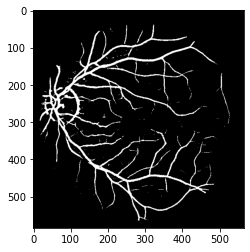

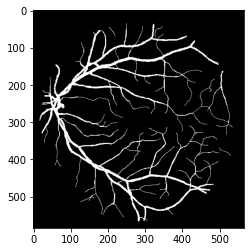

In [63]:
a, b = np.shape(masks_training[0])[0], np.shape(masks_training[0])[1]
print(a*b)
img_r = np.zeros((a*b), int)
img_r[mask_f!=0] = y_pred_train

img_f = np.reshape(img_r, (a, b))

plt.imshow(img_f, cmap = 'gray')
plt.figure()
plt.imshow(sol_training[0], cmap = 'gray')

In [65]:
print("Taxa de sucesso (Treino): ",
      np.mean(y_pred_train == Y) * 100)

print(np.unique(y_pred_train))
print(np.unique(Y))

Taxa de sucesso (Treino):  80.26381464910928
[  0. 255.]
[  0. 255.]


In [66]:
from sklearn.metrics import confusion_matrix 

tn, fp, fn, tp = confusion_matrix(Y, y_pred_train).ravel()

In [68]:
print((tp+tn)/(tp+tn+fp+fn))
print(tn, fp, fn, tp)

0.8026381464910928
174568 21138 22357 2319


In [100]:
print(l[0,:,0], l[0,:,1])
a = np.arange(225).reshape((15,15))
print(a)
print(np.mean(a[7,:]))

print(np.mean(a[l[0,:,0], l[0,:,1]]))

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14]
 [ 15  16  17  18  19  20  21  22  23  24  25  26  27  28  29]
 [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44]
 [ 45  46  47  48  49  50  51  52  53  54  55  56  57  58  59]
 [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74]
 [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89]
 [ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
 [105 106 107 108 109 110 111 112 113 114 115 116 117 118 119]
 [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]
 [135 136 137 138 139 140 141 142 143 144 145 146 147 148 149]
 [150 151 152 153 154 155 156 157 158 159 160 161 162 163 164]
 [165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
 [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194]
 [195 196 197 198 199 200 201 202 203 204 205 206 207 208 209]
 [210 211 212 213 214 215 216 217 218 2

(40, 60)


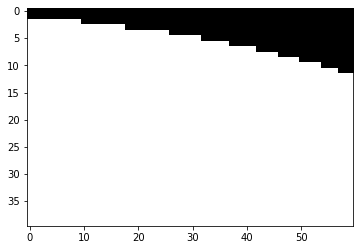

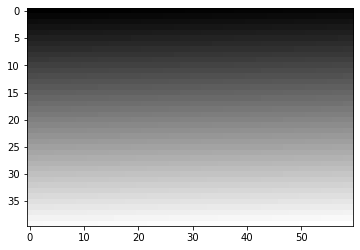

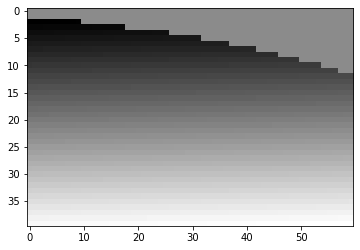

In [99]:
mask_copy = mask_test[0][30:70,300:360]
print(np.shape(mask_copy))
plt.imshow(mask_copy)
m = np.arange(40*60).reshape((40,60))
plt.figure()
plt.imshow(m)
m[mask_copy==0] = np.mean(m[mask_copy!=0])
plt.figure()
plt.imshow(m)

In [102]:
L = 3
L = max(4, L)
L = max(2, L)
L

for i in range(12):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11


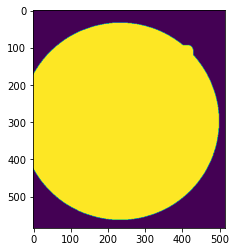

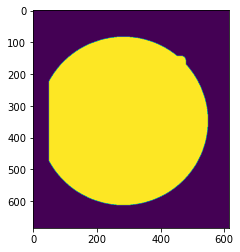

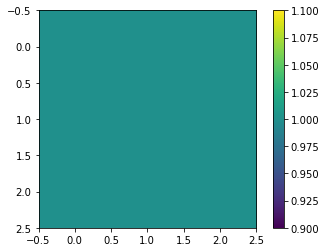

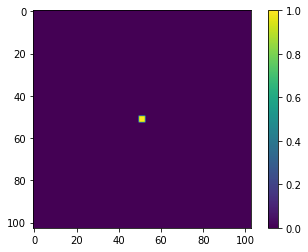

In [15]:
import matplotlib.pyplot as plt


plt.figure()
plt.imshow(mask_test[0][:,50:])
m = np.pad(mask_test[0][:,50:], ((50,50), (50,50)))

plt.figure()
plt.imshow(m)


m1 = np.ones((3,3), int)
plt.figure()
plt.imshow(m1)
plt.colorbar()
m1_ = np.pad(m1, ((50,50), (50,50)))
plt.figure()
plt.imshow(m1_)
plt.colorbar()

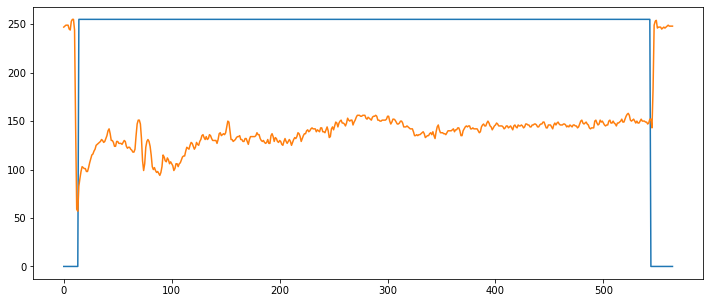

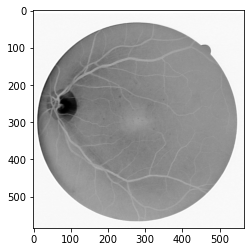

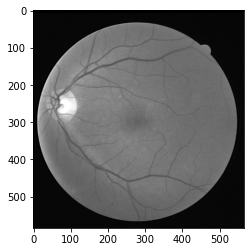

In [22]:
plt.figure(figsize = [12,5])
plt.plot(masks_training[0][300,:])
plt.plot(training[0][300,:].astype(float32)*255/np.max(training[0][300,:].astype(float32)))


plt.figure()
plt.imshow(training[0])
plt.figure()
plt.imshow(-1*training[0]+255)


In [37]:
S = [1, 2, 3, 4]

#S = np.zeros((4))
S[0] = 1
S[1] = 2
S[2] = 3
S[3] = 4
a = np.zeros((4, 3), float)
a[:,0] = S
print(a)

np.mean(S)

[[1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]]


2.5

In [16]:
m = np.ones((3,3))
m[1,:] = 2
m[2,:] = 3
m

np.random.shuffle(m)
m

array([[1., 1., 1.],
       [2., 2., 2.],
       [3., 3., 3.]])